# Datapreprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

df = pd.read_csv("Felin Dataset.csv")
print("Initial Dataset Info:")
print(df.info())

imputer = SimpleImputer(strategy="mean")
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
z_scores = np.abs((df.iloc[:, :-1] - df.iloc[:, :-1].mean()) / df.iloc[:, :-1].std())
df = df[(z_scores < 3).all(axis=1)]
df.iloc[:, :-1] += np.random.normal(0, 0.001, df.iloc[:, :-1].shape)
print("Preprocessing Complete. Saved as 'processed_dataset.csv'.")
print(df.head())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   S            2200 non-null   float64
 4   Cu           2200 non-null   float64
 5   Fe           2200 non-null   float64
 6   Mn           2200 non-null   float64
 7   Zn           2200 non-null   float64
 8   QV2M-W       2200 non-null   float64
 9   QV2M-AU      2200 non-null   float64
 10  QV2M-SP      2200 non-null   float64
 11  temperature  2200 non-null   float64
 12  humidity     2200 non-null   float64
 13  ph           2200 non-null   float64
 14  rainfall     2200 non-null   float64
 15  label        2200 non-null   object 
dtypes: float64(12), int64(3), object(1)
memory usage: 275.1+ KB
None
Preprocessing Complete. Saved as 'processed_d

<ipython-input-91-9099e948b52c>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.64285714 0.60714286 0.42857143 ... 0.84285714 0.83571429 0.74285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
<ipython-input-91-9099e948b52c>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.26428571 0.37857143 0.35714286 ... 0.2        0.19285714 0.09285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
<ipython-input-91-9099e948b52c>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19  0.18  0.195 ... 0.125 0.145 0.125]' has dtype incompatible with int64, please explicitly cast t

# Sampling techniques

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, mean_absolute_error
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("processed_dataset.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

classifiers = {
    "NB": GaussianNB(),
    "DT": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "kNN": KNeighborsClassifier(),
    "Bagging": BaggingClassifier(),
    "RF": RandomForestClassifier()
}

sampling_methods = {
    "Without_Sampling": None,
    "SMOTE": SMOTE(),
    "MWMOTE": SMOTETomek(),
    "ROSE": RandomUnderSampler()
}

def evaluate_model(y_true, y_pred, y_prob):
    num_classes = len(np.unique(y_true))
    return {
        "ACC": accuracy_score(y_true, y_pred),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "P": precision_score(y_true, y_pred, average="weighted"),
        "R": recall_score(y_true, y_pred, average="weighted"),
        "Sp": np.mean(recall_score(y_true, y_pred, average=None)),  # Approximate Specificity for multiclass
        "F1": f1_score(y_true, y_pred, average="weighted"),
        "AUC": roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted") if num_classes > 2 else roc_auc_score(y_true, y_prob[:, 1]),
        "MAE": mean_absolute_error(y_true, y_pred),
        "Log Loss": log_loss(y_true, y_prob)
    }

results = []

for sampling_name, sampler in sampling_methods.items():
    if sampler:
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train

    resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    resampled_df["Target"] = y_resampled
    resampled_df.to_csv(f"resampled_{sampling_name}.csv", index=False)

    for clf_name, clf in classifiers.items():
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)
        metrics = evaluate_model(y_test, y_pred, y_prob)
        metrics["Sampling"] = sampling_name
        metrics["Classifier"] = clf_name
        results.append(metrics)

results_df = pd.DataFrame(results)

results_df.to_csv("classification_results.csv", index=False)

print(results_df)


         ACC     Kappa         P         R        Sp        F1       AUC  \
0   0.744828  0.732285  0.747871  0.744828  0.748993  0.743924  0.986174   
1   0.522167  0.498729  0.523127  0.522167  0.527850  0.520054  0.749291   
2   0.629557  0.611245  0.638014  0.629557  0.623644  0.628457  0.973573   
3   0.374384  0.343344  0.399551  0.374384  0.377535  0.370443  0.806392   
4   0.622660  0.604112  0.627450  0.622660  0.624390  0.622177  0.925943   
5   0.710345  0.696040  0.713401  0.710345  0.712718  0.705986  0.979898   
6   0.736946  0.724057  0.739787  0.736946  0.742251  0.736475  0.985674   
7   0.517241  0.493696  0.522415  0.517241  0.520827  0.516041  0.746859   
8   0.626601  0.608302  0.632735  0.626601  0.627567  0.626914  0.973473   
9   0.370443  0.339801  0.390953  0.370443  0.375927  0.368035  0.804218   
10  0.615764  0.596913  0.621774  0.615764  0.617421  0.613525  0.927468   
11  0.679803  0.664091  0.686535  0.679803  0.683237  0.676493  0.980212   
12  0.709360

selected sampling technique (SMOTE)


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

df = pd.read_csv("processed_dataset.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Class"] = y_resampled

df_resampled.to_csv("swote_crop_no.csv", index=False)

print("Resampled dataset saved as 'swote_resampled_dataset.csv'.")


Resampled dataset saved as 'swote_resampled_dataset.csv'.


# Feature Selection

Linear Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.read_csv("swote_crop_no.csv")

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

results = []

for column in X.columns:
    X_single = X[[column]].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X_single, y, test_size=0.5, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    results.append({"Attribute": column, "R2 Score": r2})
results_df = pd.DataFrame(results)

threshold = 0.05
selected_features = results_df[results_df["R2 Score"] > threshold]["Attribute"].tolist()

results_df.to_csv("linear_reg_result.csv", index=False)
pd.DataFrame(selected_features, columns=["Selected Features"]).to_csv("selected_features.csv", index=False)

print("All Features with R² Scores:")
print(results_df)


All Features with R² Scores:
      Attribute  R2 Score
0             N  0.000793
1             P  0.203276
2             K  0.104371
3             S -0.009334
4            Cu  0.000715
5            Fe -0.000202
6            Mn -0.001261
7            Zn -0.004648
8        QV2M-W -0.000498
9       QV2M-AU -0.000017
10      QV2M-SP -0.001314
11  temperature  0.002190
12     humidity  0.027610
13           ph -0.000372
14     rainfall -0.000568


<ipython-input-6-2cd2a896deea>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Attribute", y="R2 Score", data=df, palette="viridis")


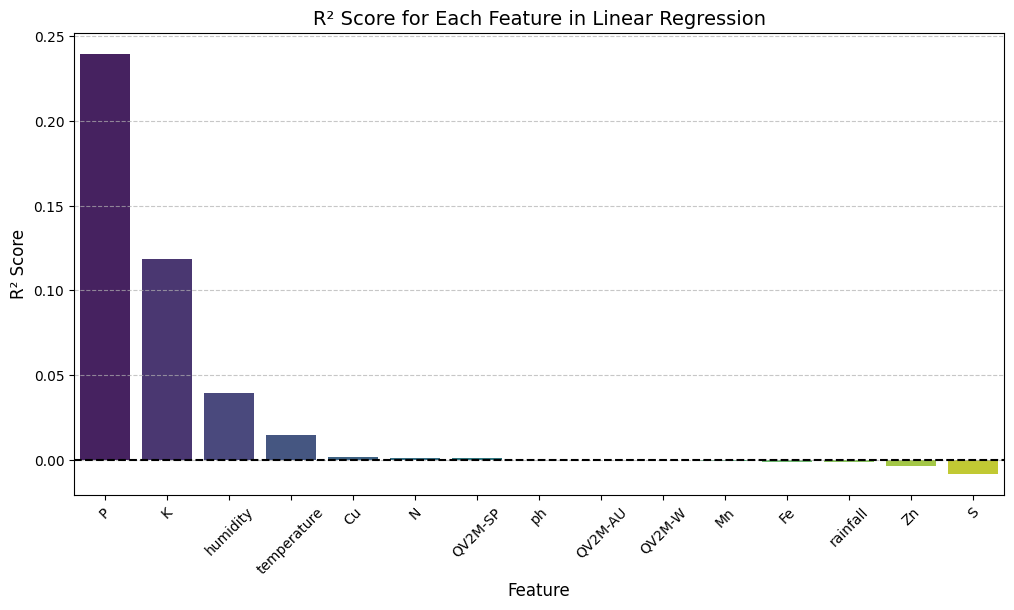

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "Attribute": ["N", "P", "K", "S", "Cu", "Fe", "Mn", "Zn", "QV2M-W", "QV2M-AU", "QV2M-SP", "temperature", "humidity", "ph", "rainfall"],
    "R2 Score": [0.001317, 0.239579, 0.118702, -0.008316, 0.001951, -0.001019, -0.000861, -0.003779, -0.000372, 0.000002, 0.000943, 0.014637, 0.039450, 0.000142, -0.001525]
}

df = pd.DataFrame(data)
df = df.sort_values(by="R2 Score", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Attribute", y="R2 Score", data=df, palette="viridis")

plt.xlabel("Feature", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Score for Each Feature in Linear Regression", fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()



FEATURE SELECTION USING PCA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv("swote_crop_no.csv")
X = df.iloc[:, :-1]

top_n_features = 7

cov_matrix = X.cov()
cov_table = cov_matrix.round(3)
print("Covariance Matrix (3-decimal precision):")
print(cov_table)

cor_matrix = X.corr().abs()
cor_matrix_values = cor_matrix.unstack().sort_values(ascending=False)
cor_matrix_values = cor_matrix_values[cor_matrix_values < 1.0]

threshold = cor_matrix_values.quantile(0.9)

chains = []
visited = set()
all_features = set(X.columns)

def build_chain(feature, chain):
    visited.add(feature)
    chain.append(feature)
    for (f1, f2) in cor_matrix_values.index:
        if cor_matrix.loc[f1, f2] > threshold:
            if f1 == feature and f2 not in visited:
                build_chain(f2, chain)
            elif f2 == feature and f1 not in visited:
                build_chain(f1, chain)

for (f1, f2) in cor_matrix_values.index:
    if cor_matrix.loc[f1, f2] > threshold and f1 not in visited:
        chain = []
        build_chain(f1, chain)
        chains.append(chain)

unvisited_features = all_features - visited
for feature in unvisited_features:
    chains.append([feature])

print("Feature Chains:", chains)

top_features = []
for chain in chains:
    if len(top_features) >= top_n_features:
        break
    top_features.extend(chain)

if len(top_features) < top_n_features:
    remaining_features = list(set(X.columns) - set(top_features))
    additional_features = cov_matrix.loc[remaining_features, remaining_features].sum().nlargest(top_n_features - len(top_features)).index.tolist()
    top_features.extend(additional_features)

print(f"Top {top_n_features} Features:", top_features[:top_n_features])

pca = PCA(n_components=top_n_features)
X_pca = pca.fit_transform(X[top_features[:top_n_features]])

Covariance Matrix (3-decimal precision):
                 N      P      K      S     Cu     Fe     Mn     Zn  QV2M-W  \
N            0.077 -0.015 -0.011 -0.001 -0.002 -0.000  0.002 -0.002   0.001   
P           -0.015  0.067  0.045 -0.001  0.002 -0.002 -0.002  0.001   0.002   
K           -0.011  0.045  0.072 -0.001  0.006 -0.003 -0.003 -0.000   0.004   
S           -0.001 -0.001 -0.001  0.093 -0.001  0.004  0.001 -0.001   0.003   
Cu          -0.002  0.002  0.006 -0.001  0.094  0.002  0.001  0.003   0.000   
Fe          -0.000 -0.002 -0.003  0.004  0.002  0.088  0.003 -0.003   0.001   
Mn           0.002 -0.002 -0.003  0.001  0.001  0.003  0.091  0.001   0.002   
Zn          -0.002  0.001 -0.000 -0.001  0.003 -0.003  0.001  0.092  -0.002   
QV2M-W       0.001  0.002  0.004  0.003  0.000  0.001  0.002 -0.002   0.097   
QV2M-AU     -0.002  0.005  0.004 -0.004  0.000 -0.005  0.001 -0.001  -0.000   
QV2M-SP      0.000  0.000  0.000 -0.000 -0.003 -0.001  0.001  0.004   0.000   
temperature

Information gain of features:
        Feature  Importance
12     humidity    0.231067
0             N    0.207968
14     rainfall    0.157942
1             P    0.121859
2             K    0.116886
11  temperature    0.042756
13           ph    0.036401
10      QV2M-SP    0.014047
3             S    0.012834
5            Fe    0.011042
7            Zn    0.010637
8        QV2M-W    0.010209
4            Cu    0.009475
9       QV2M-AU    0.008576
6            Mn    0.008301


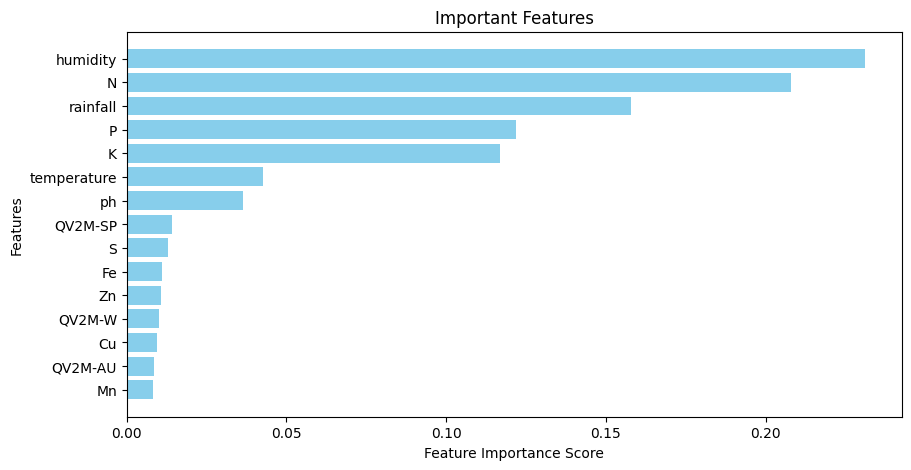

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

file_path = "swote_crop_no.csv"
df = pd.read_csv(file_path)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False)
top_6_features = importance_df.head(15)

print("Information gain of features:")
print(top_6_features)

plt.figure(figsize=(10, 5))
plt.barh(top_6_features["Feature"], top_6_features["Importance"], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Important Features")
plt.gca().invert_yaxis()
plt.show()

Decision Tree

Boruta,RFE,MRFE

In [ ]:
!pip install boruta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from boruta import BorutaPy
def select_features_rfe(X, y, n_features=10):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_].tolist()
    return selected_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import numpy as np

def select_features_mrfe(X, y, n_features=10, step_fraction=0.1):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    total_features = X.shape[1]
    step = max(1, int(total_features * step_fraction))  # At least 1 feature per step

    rfe = RFE(model, n_features_to_select=n_features, step=step)
    rfe.fit(X, y)

    selected_features = X.columns[rfe.support_].tolist()
    return selected_features

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

def select_features_boruta(X, y, n_features=9):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    boruta = BorutaPy(model, n_estimators='auto', verbose=0, random_state=42)
    boruta.fit(X.values, y)

    selected_features = X.columns[boruta.support_].tolist()

    if len(selected_features) > n_features:
        selected_features = selected_features[:n_features]

    return selected_features

In [ ]:
def run_feature_selection(df, target_column, rfe_features=8, mrfe_features=6, boruta_features=9):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    global rfe_selected, mrfe_selected, boruta_selected

    rfe_selected = select_features_rfe(X, y, rfe_features)
    mrfe_selected = select_features_mrfe(X, y, mrfe_features, step_fraction=0.1)
    boruta_selected = select_features_boruta(X, y, boruta_features)

df_smote = pd.read_csv("swote_crop_no.csv")
run_feature_selection(df_smote, target_column="label", rfe_features=8, mrfe_features=6, boruta_features=9)

print("RFE Selected Features:", rfe_selected)
print("MRFE Selected Features:", mrfe_selected)
print("Boruta Selected Features:", boruta_selected)

RFE Selected Features: ['N', 'P', 'K', 'QV2M-SP', 'temperature', 'humidity', 'ph', 'rainfall']
MRFE Selected Features: ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']
Boruta Selected Features: ['N', 'P', 'K', 'QV2M-W', 'QV2M-SP', 'temperature', 'humidity', 'ph', 'rainfall']


<ipython-input-25-e63f1139aaef>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


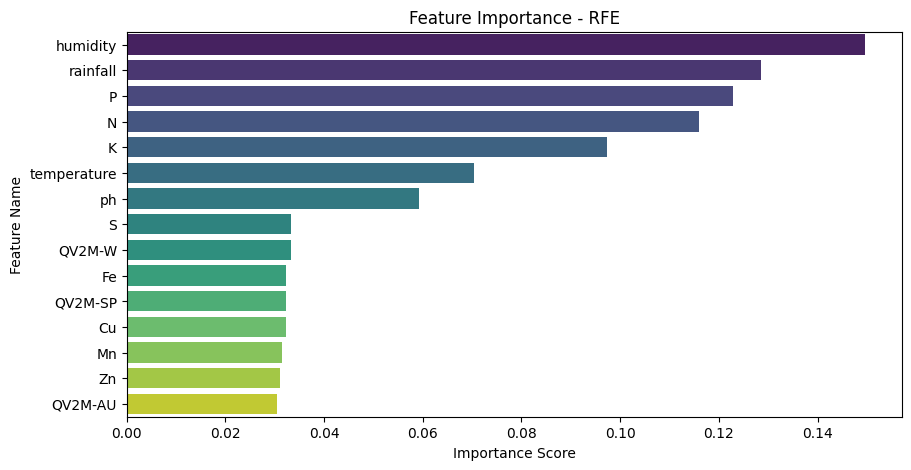

<ipython-input-25-e63f1139aaef>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


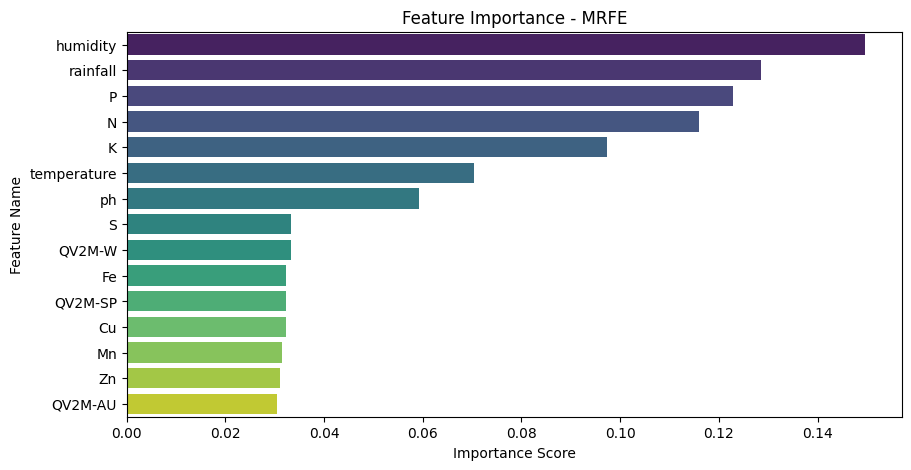

<ipython-input-25-e63f1139aaef>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


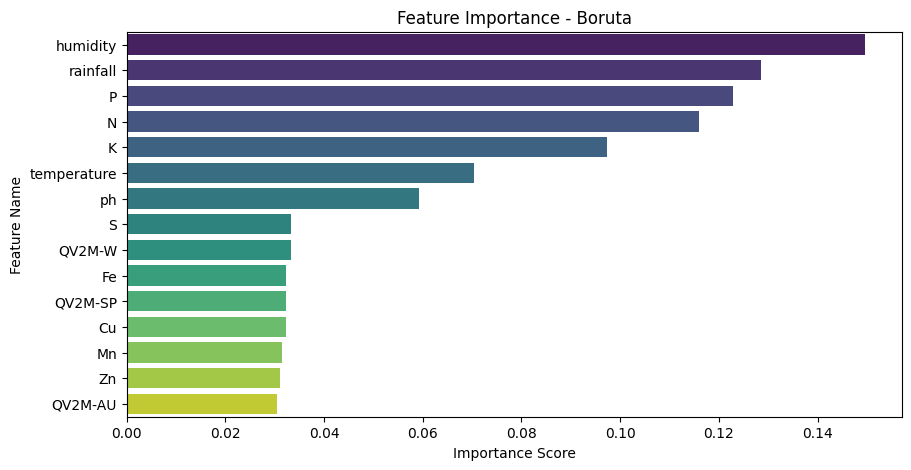

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(df, selected_features, method_name, target_column, all_features):
    """Computes feature importance scores using Random Forest and ensures all 15 features are present."""
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values(by="Importance", ascending=False)


    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance - {method_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.show()

all_features = df_smote.columns.tolist()
all_features.remove("Class")

plot_feature_importance(df_smote, rfe_selected, "RFE", "label", all_features)
plot_feature_importance(df_smote, mrfe_selected, "MRFE", "label", all_features)
plot_feature_importance(df_smote, boruta_selected, "Boruta", "label", all_features)

# Model Selection


## Datapreprocssing for selected features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import joblib

df = pd.read_csv("Crop_Recommendation.csv")

print("Initial Dataset Info:")
print(df.info())

imputer = SimpleImputer(strategy="mean")
df.iloc[:, 1:-1] = imputer.fit_transform(df.iloc[:, 1:-1])

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
joblib.dump(label_encoder, "label_encoder.pkl")


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])
joblib.dump(scaler, "scaler.pkl")


z_scores = np.abs((df.iloc[:, :-1] - df.iloc[:, :-1].mean()) / df.iloc[:, :-1].std())
df = df[(z_scores < 3).all(axis=1)]

df.to_csv("Crop_Recommendationdataset.csv", index=False)

print(df.head())
from imblearn.over_sampling import SMOTE
import pandas as pd

df = pd.read_csv("Crop_Recommendationdataset.csv")
X = df.iloc[:, [1,2,3,4,5,6]]
y = df.iloc[:, -1]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Class"] = y_resampled

df_resampled.to_csv("croprecommendation.csv", index=False)

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
    N         P      K  temperature  humidity        ph  rainfall  label
0  90  0.264286  0.190     0.345886  0.790267  0.466264  0.656458     20
1  85  0.378571  0.180     0.371445  0.770633  0.549480  0.741675     20
2  60  0.357143  0.195     0.406854  0.793977  0.674219  0.875710     20
3  74  0.214286  0.175     0.506901  0.768751  0.540508  0.799905     20
4  78  0.264286  0

<ipython-input-2-2896d8c74af5>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.26428571 0.37857143 0.35714286 ... 0.2        0.19285714 0.09285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])
<ipython-input-2-2896d8c74af5>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19  0.18  0.195 ... 0.125 0.145 0.125]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, mean_absolute_error
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

df = pd.read_csv('swote_crop_no.csv')
X = df.iloc[:, [0,1,2,12,13,14]]
y = df.iloc[:, -1]

from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data, data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

classifiers = {
    "NB": GaussianNB(var_smoothing=1e-1),
    "DT": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "Bagging": BaggingClassifier(),
    "RF": RandomForestClassifier()
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    num_classes = len(np.unique(y))

    metrics = {
        "Classifier": name,
        "ACC": accuracy_score(y_test, y_pred),
        "Kappa": cohen_kappa_score(y_test, y_pred),
        "P": precision_score(y_test, y_pred, average="weighted"),
        "R": recall_score(y_test, y_pred, average="weighted"),
        "Sp": np.mean(recall_score(y_test, y_pred, average=None)),
        "F1": f1_score(y_test, y_pred, average="weighted"),
        "AUC": roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted") if num_classes > 2 else roc_auc_score(y_test, y_prob[:, 1]),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Log Loss": log_loss(y_test, y_prob)
    }
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

  Classifier       ACC     Kappa         P         R        Sp        F1  \
0         NB  0.986667  0.979871  0.987222  0.986667  0.985507  0.986660   
1         DT  0.946667  0.919485  0.954568  0.946667  0.942029  0.946260   
2        kNN  0.946667  0.919485  0.954568  0.946667  0.942029  0.946260   
3    Bagging  0.973333  0.959742  0.975467  0.973333  0.971014  0.973283   
4         RF  0.986667  0.979871  0.987222  0.986667  0.985507  0.986660   

        AUC       MAE  Log Loss  
0  1.000000  0.013333  0.125561  
1  0.961538  0.053333  1.922328  
2  0.998974  0.053333  0.080342  
3  0.997692  0.026667  0.076915  
4  1.000000  0.013333  0.066499  


In [ ]:
pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0197616

=== Evaluation Metrics ===
Accuracy: 0.9984
Kappa: 0.9983
Precision (weighted): 0.9984
Recall (weighted): 0.9984
Specificity (mean of individual recalls): 0.9985
F1-score (weighted): 0.9984
AUC (weighted OVR): 1.0000
MAE: 0.0082
Log Loss: 0.0198

Confusion Matrix:
 [[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0 

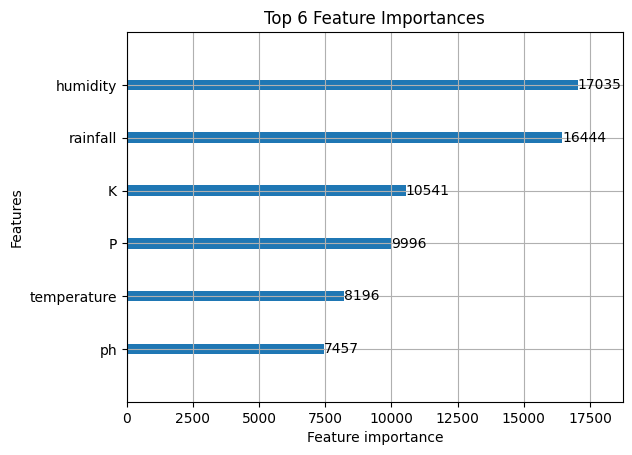

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    cohen_kappa_score, precision_score, recall_score,
    f1_score, roc_auc_score, mean_absolute_error, log_loss
)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Load dataset
df = pd.read_csv("Crop_Recommendationdataset.csv")
X = df.iloc[:, [1, 2, 3, 4, 5, 6]]
y = df.iloc[:, -1]

# Encode target labels if not numeric
if not np.issubdtype(y.dtype, np.number):
    le = LabelEncoder()
    y = le.fit_transform(y)

num_classes = len(np.unique(y))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define and train model
model = LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    learning_rate=0.05,
    n_estimators=1000,
    num_leaves=31,
    verbose=-1
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=0)
    ]
)

# Prediction
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# If multiclass, binarize for AUC
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Kappa": cohen_kappa_score(y_test, y_pred),
    "Precision (weighted)": precision_score(y_test, y_pred, average="weighted"),
    "Recall (weighted)": recall_score(y_test, y_pred, average="weighted"),
    "Specificity (mean of individual recalls)": np.mean(recall_score(y_test, y_pred, average=None)),
    "F1-score (weighted)": f1_score(y_test, y_pred, average="weighted"),
    "AUC (weighted OVR)": roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="weighted"),
    "MAE": mean_absolute_error(y_test, y_pred),
    "Log Loss": log_loss(y_test, y_prob)
}

# Print all metrics
print("\n=== Evaluation Metrics ===")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Extra reports
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance plot
plot_importance(model, max_num_features=10)
plt.title("Top 6 Feature Importances")
plt.show()